In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

from sklearn.linear_model import LinearRegression
from commons.time_series import *

In [2]:
data_path = Path('data', 'store-sales')
data_prepared_path = Path('data', 'store-sales', 'prepared')
holidays = pd.read_csv(
    data_path / 'holidays_events.csv',
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)


# test = pd.read_csv(data_path / 'test.csv')

# Holiday analysis

In [3]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [4]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    category      
 2   locale       350 non-null    category      
 3   locale_name  350 non-null    category      
 4   description  350 non-null    category      
 5   transferred  350 non-null    bool          
dtypes: bool(1), category(4), datetime64[ns](1)
memory usage: 10.5 KB


In [5]:
holidays.describe(include='all').drop('top')

,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,NaN,6,3,24,103,2
freq,NaN,221,174,174,10,338
mean,2015-04-24 00:45:15.428571392,NaN,NaN,NaN,NaN,NaN
min,2012-03-02 00:00:00,NaN,NaN,NaN,NaN,NaN
25%,2013-12-23 06:00:00,NaN,NaN,NaN,NaN,NaN
50%,2015-06-08 00:00:00,NaN,NaN,NaN,NaN,NaN
75%,2016-07-03 00:00:00,NaN,NaN,NaN,NaN,NaN
max,2017-12-26 00:00:00,NaN,NaN,NaN,NaN,NaN


In [6]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [7]:
holidays[holidays['transferred'] == True]

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


In [8]:
holidays[holidays['type'] == 'Transfer']

,date,type,locale,locale_name,description,transferred
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False
269,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
298,2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False
304,2017-04-13,Transfer,Local,Cuenca,Fundacion de Cuenca,False
313,2017-05-26,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False


### Since some of the holidays were transfered to other day, I want to keep only the records with holidays that were celebrated at this time. The celebration date of the holiday affect the store sale, not the calendar holiday day.

```Python
holidays['transferred'] == False
```
Will give the result only with celebration dates (both transfered and not)

In [9]:
holidays = holidays[holidays['transferred'] == False]

In [10]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [11]:
holidays['description'] = holidays['description'].str.replace('Traslado ', '')
holidays.drop('transferred', axis=1, inplace=True)  # No longer needed

In [12]:
holidays.to_csv(data_prepared_path / 'holidays.csv', index=False)

# Oil analysis

Since Ecuador is oil-dependent country, oil prices may be useful in our store sales predictions

In [13]:
oil = pd.read_csv(
    data_path / 'oil.csv',
    parse_dates=['date']
)
oil.set_index('date', inplace=True)

In [14]:
oil.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


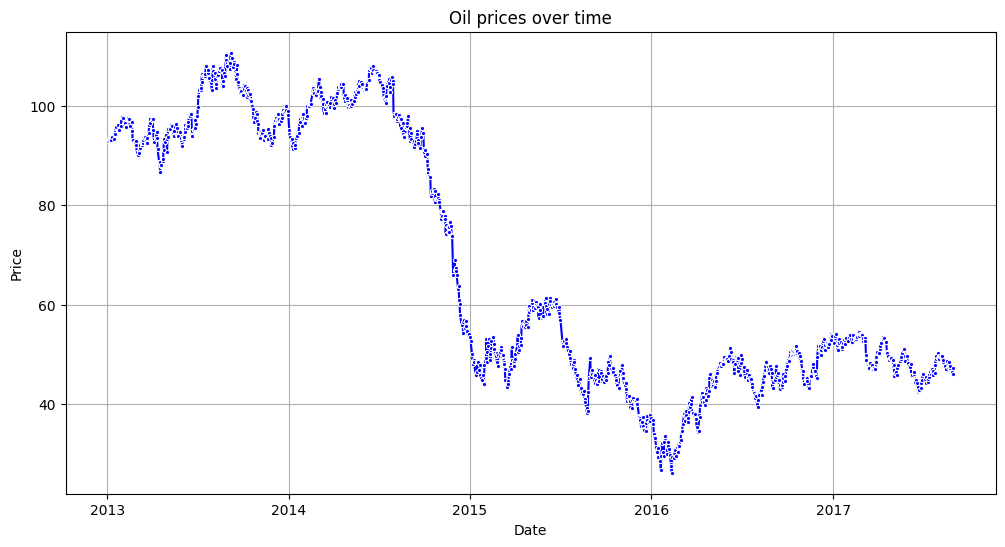

In [15]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=oil, x=oil.index, y='dcoilwtico', marker='.', color='b')
plt.xlabel('Date')
plt.ylabel('Price'),
plt.title('Oil prices over time')
plt.grid()

# Stores analysis

In [16]:
stores = pd.read_csv(
    data_path / 'stores.csv',
    dtype={
        'city': 'category',
        'state': 'category',
        'type': 'category'
    }
)

In [17]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


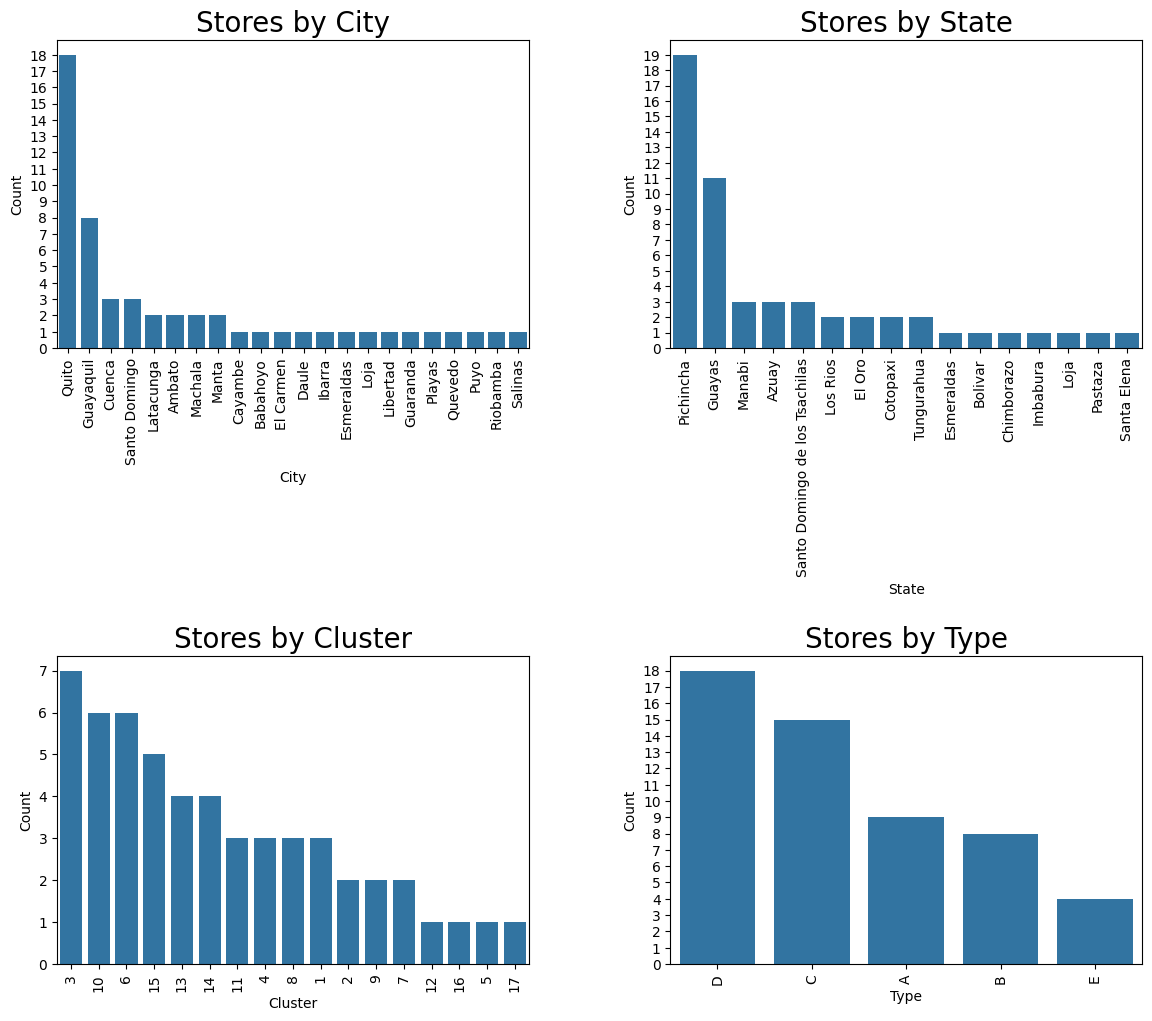

In [18]:
def plot_store_counts(df, columns):
    """
    Plots bar charts for the count of stores based on given categorical columns in a 2x2 subplot layout.

    Parameters:
    df (pd.DataFrame): The dataframe containing store data.
    columns (list): List of column names to plot (max 4 for 2x2 layout).
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()

    for i, col in enumerate(columns[:4]):
        sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=axes[i])
        axes[i].set_title(f"Stores by {col.capitalize()}", fontsize=20)
        axes[i].set_xlabel(col.capitalize())
        axes[i].set_ylabel("Count")
        axes[i].tick_params(axis='x', rotation=90)
        
        # Changing y axis show integer values only
        max_count = df[col].value_counts().max()
        axes[i].set_yticks(np.arange(0, max_count + 1, step=1))

    # Hide unused subplots if columns < 4
    for j in range(len(columns), 4):
        fig.delaxes(axes[j])

    # Prevent lab
    plt.subplots_adjust(hspace=1, wspace=0.3)  
    plt.show()

# fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# axes = axes.flatten()
plot_store_counts(stores, ["city", "state", "cluster", "type"])  # Pass up to 4 columns

# Train data analysis

In [19]:
store_sales = pd.read_csv(
    data_path / 'train.csv',
    dtype = {
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint64',
    },
    parse_dates=['date'],
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)

In [20]:
store_sales.head()

id  sales  onpromotion
date       store_nbr family                            
2013-01-01 1         AUTOMOTIVE   0    0.0            0
                     BABY CARE    1    0.0            0
                     BEAUTY       2    0.0            0
                     BEVERAGES    3    0.0            0
                     BOOKS        4    0.0            0

## Identifying trend in store sales

In [21]:
average_sales = store_sales.groupby('date').mean()['sales']

Text(0, 0.5, 'Sales')

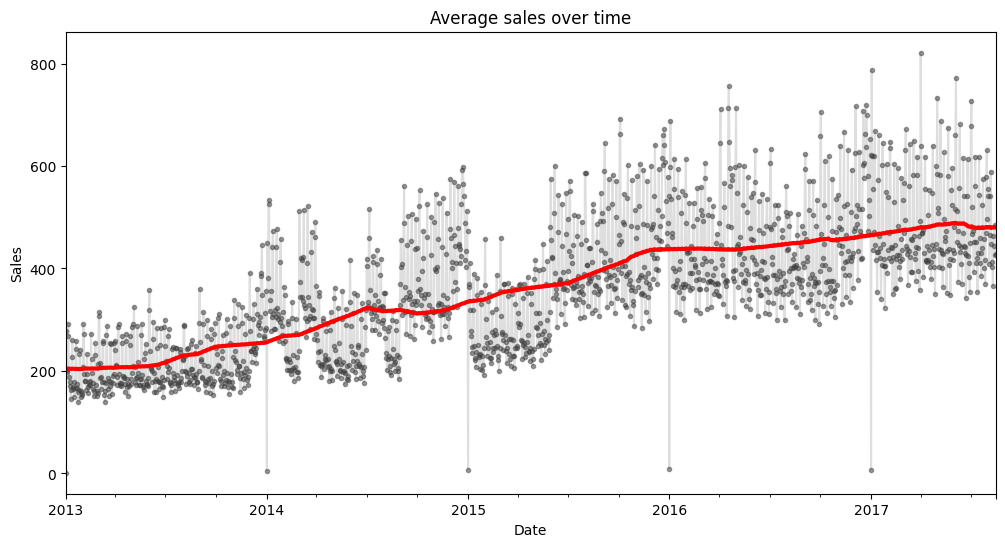

In [22]:
from commons.plot_config import PLOT_PARAMS

trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183
).mean()

ax = average_sales.plot(**PLOT_PARAMS, alpha=0.5)
ax = trend.plot(linewidth=3, color='r')
ax.set_title('Average sales over time')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

## Creating Trend feature

In [23]:
y = average_sales.copy()

dp = DeterministicProcess(
    index=y.index,
    order=3,
    drop=True
)

X = dp.in_sample()

X_forecast = dp.out_of_sample(steps=30)


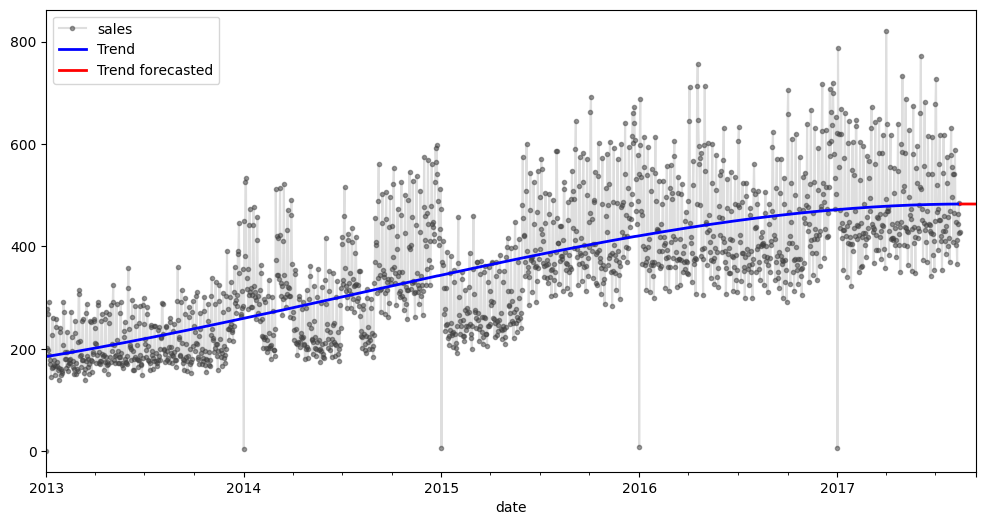

In [24]:
lm = LinearRegression().fit(X, y)

y_pred = pd.Series(
    lm.predict(X),
    index=X.index
)

y_fore = pd.Series(
    lm.predict(X_forecast),
    index=X_forecast.index
)

plt.figure(figsize=(12, 6))
ax = y.plot(**PLOT_PARAMS, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=2, label='Trend', color='b')
ax = y_fore.plot(ax=ax, linewidth=2, label='Trend forecasted', color='r')
ax.legend()


## Seasonal plot

<Axes: title={'center': 'Seasonal Plot (week/day)'}, xlabel='day', ylabel='sales'>

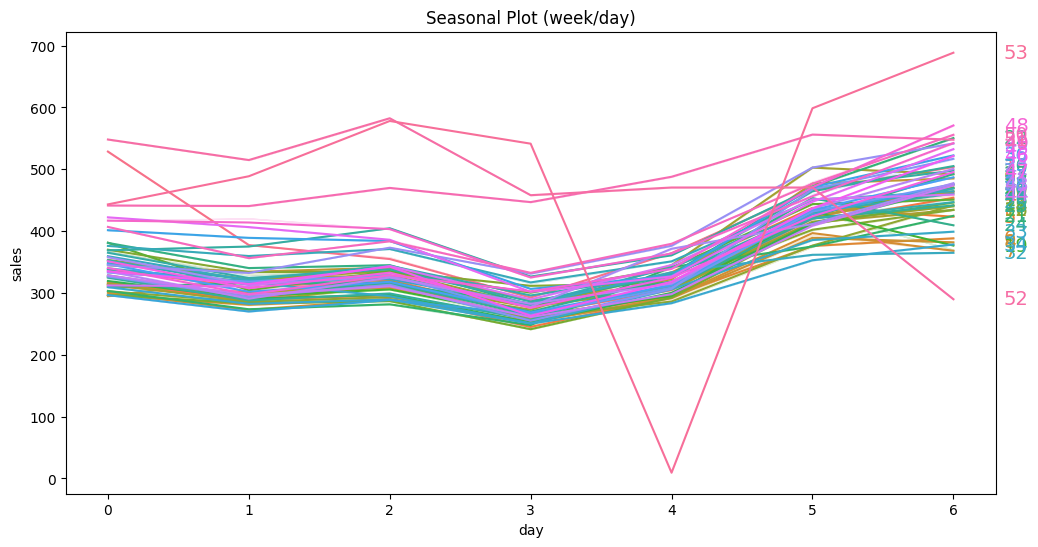

In [25]:
plt.rcParams["figure.figsize"] = (12, 6)  

X = average_sales.to_frame()
X['week'] = X.index.week
X['day'] = X.index.dayofweek

seasonal_plot(X, 'sales', period='week', freq='day')

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

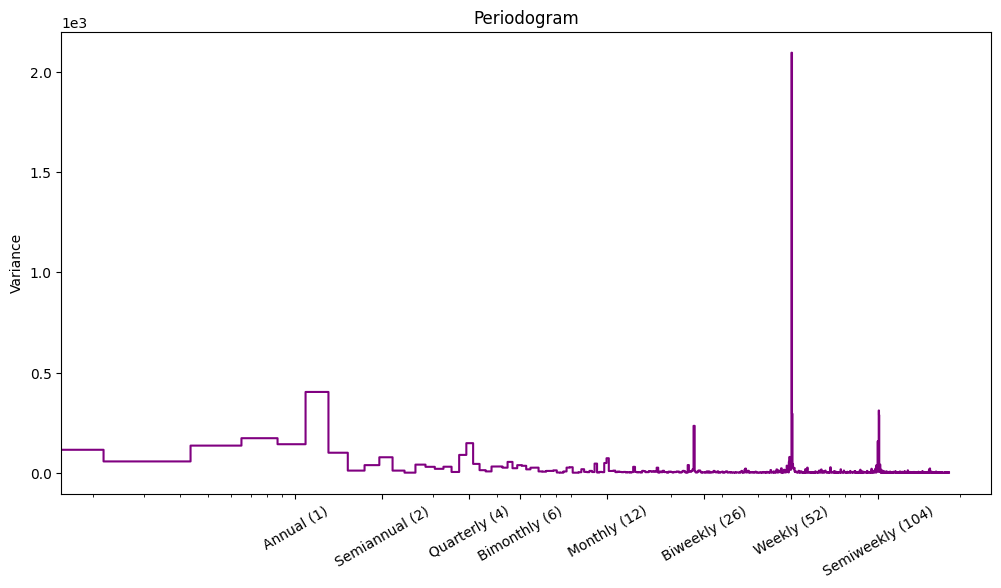

In [26]:
plot_periodogram(average_sales)

Strong weekly seasonality, Periodogram may suggest also monthy and biweekly. Dataset description says that pubilc sector is paid biweekly on 15th and last day of month

## Creating seasonal features

In [27]:
y = average_sales.copy()

def create_seasonal_features(y, freq='M', fourier_order=4, dp_order=1):
    
    fourier = CalendarFourier(freq=freq, order=fourier_order)
    dp = DeterministicProcess(
        index=y.index,
        constant=True,
        order=dp_order,
        seasonal=True,
        additional_terms=[fourier],
        drop=True
    )
    X = dp.in_sample()

    lm = LinearRegression().fit(X, y)
    y_pred = pd.Series(
        lm.predict(X),
        index=X.index,
        name='Fitted'
    )
    
    return y_pred

def plot_average_sales(y, y_pred):
    ax = y.plot(**PLOT_PARAMS, alpha=0.65, title='Average sales', ylabel='Sold items')
    ax = y_pred.plot(ax=ax, label='Seasonal')
    ax.legend()
    
def desesonalize_and_plot(y, y_pred):
    y_des = y - y_pred

    fig, (a1, a2) = plt.subplots(2, 1, sharex=True, sharey=True)
    a1 = plot_periodogram(y, ax=a1)
    a1.set_title('Sale frequency components')

    a2 = plot_periodogram(y_des, ax=a2)
    a1.set_title('Deseasonalized sale frequency components')


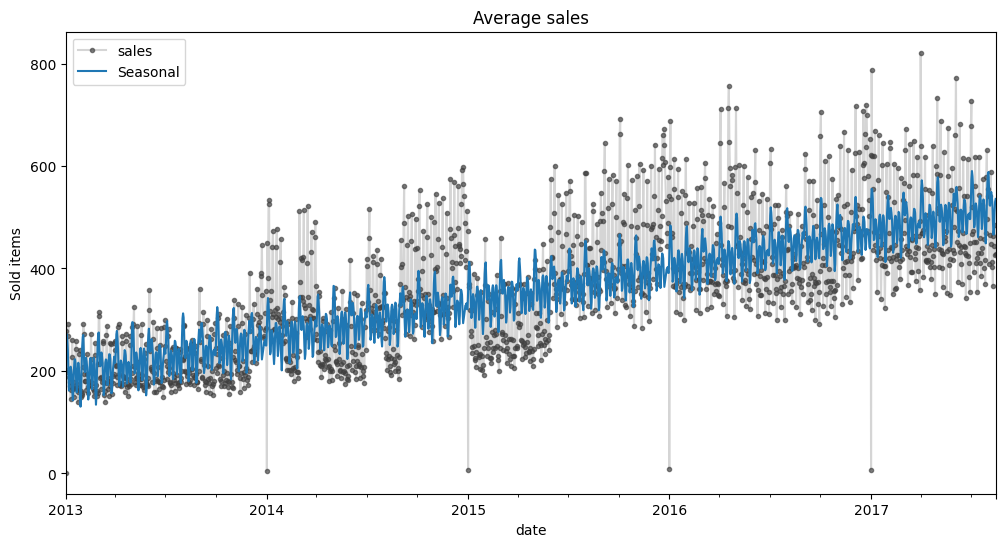

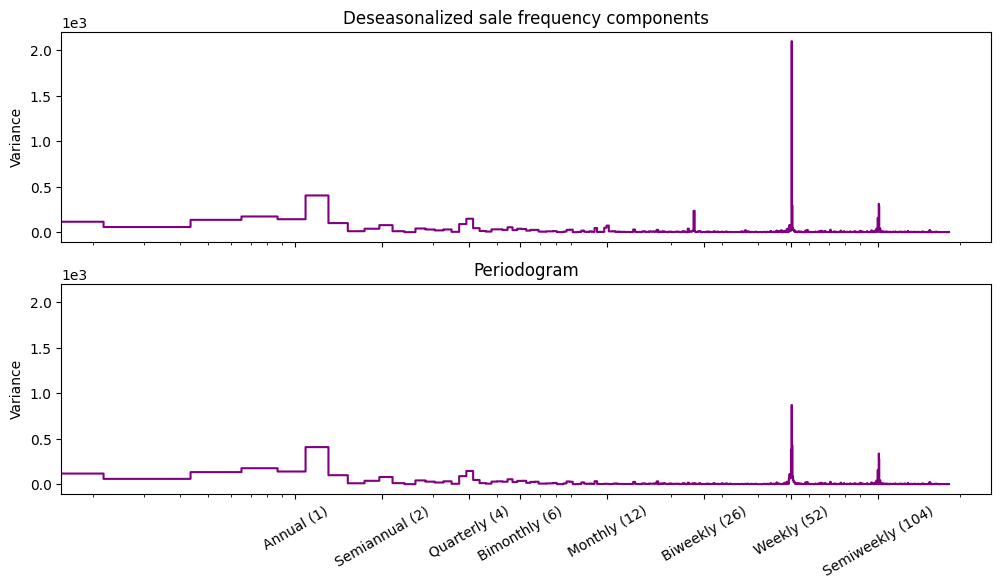

In [28]:
y_pred = create_seasonal_features(y, freq='M', fourier_order=4, dp_order=1)
plot_average_sales(y, y_pred)
desesonalize_and_plot(y, y_pred)

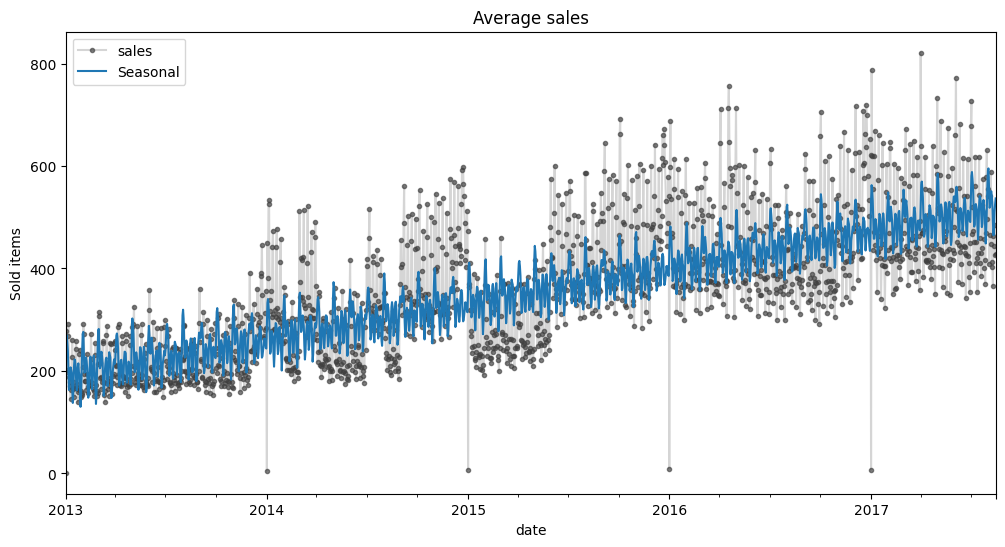

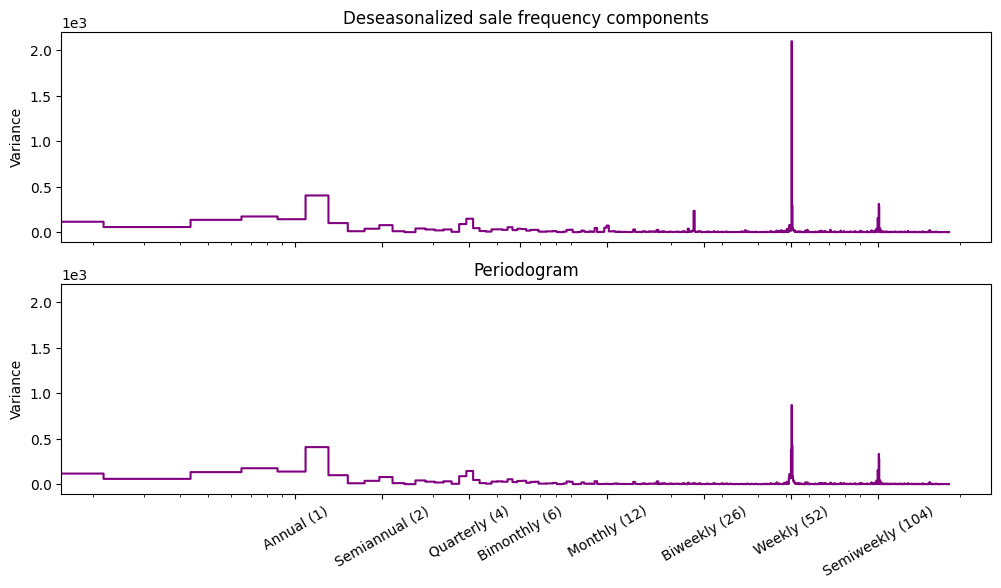

In [29]:
y_pred = create_seasonal_features(y, freq='M', fourier_order=12, dp_order=1)
plot_average_sales(y, y_pred)
desesonalize_and_plot(y, y_pred)

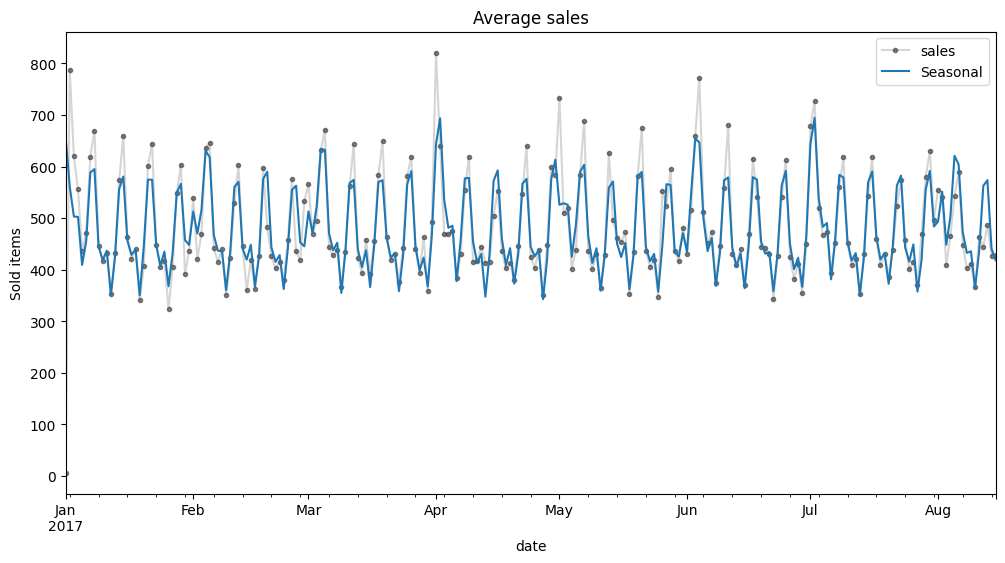

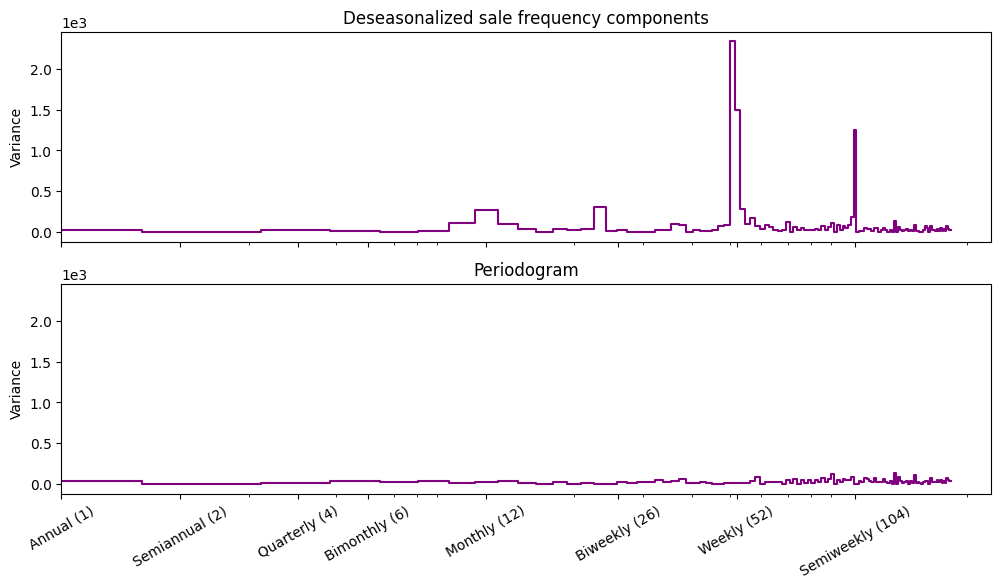

In [30]:
y = average_sales.loc['2017'].copy()

y_pred = create_seasonal_features(y, freq='M', fourier_order=12, dp_order=1)
plot_average_sales(y, y_pred)
desesonalize_and_plot(y, y_pred)

In [31]:
from statsmodels.graphics.tsaplots import plot_acf

y = average_sales.copy().to_frame()



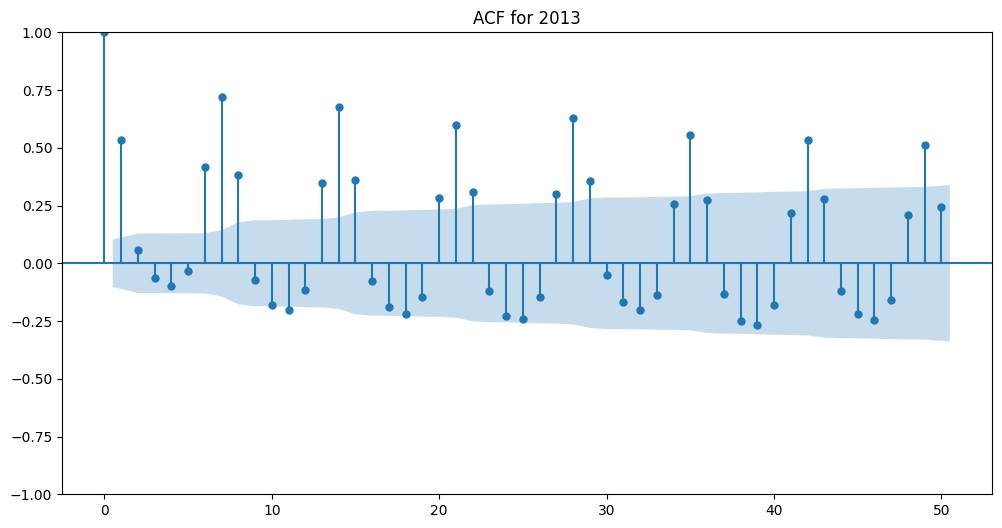

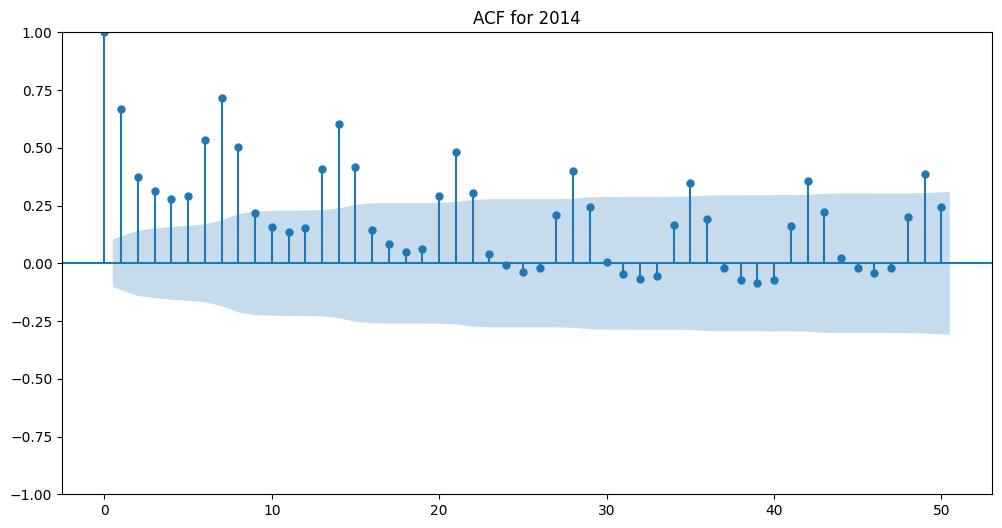

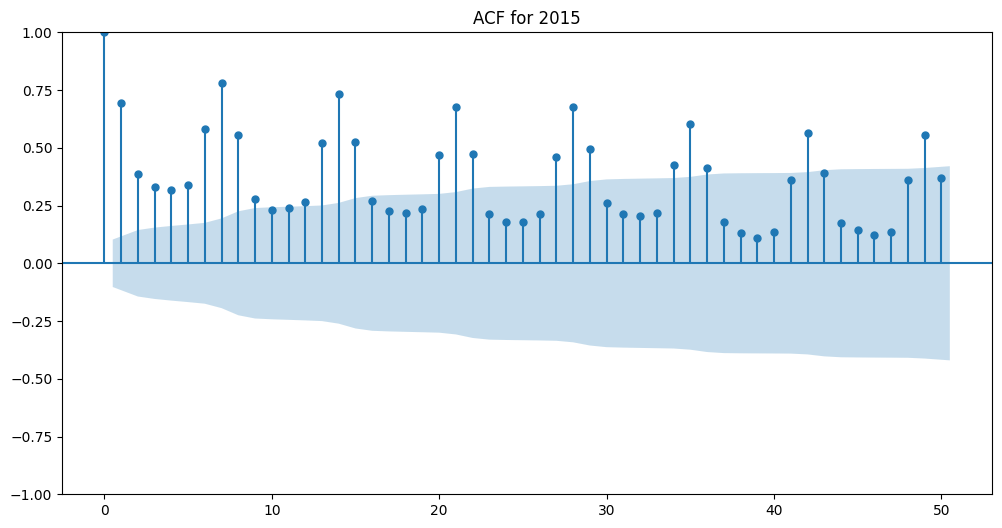

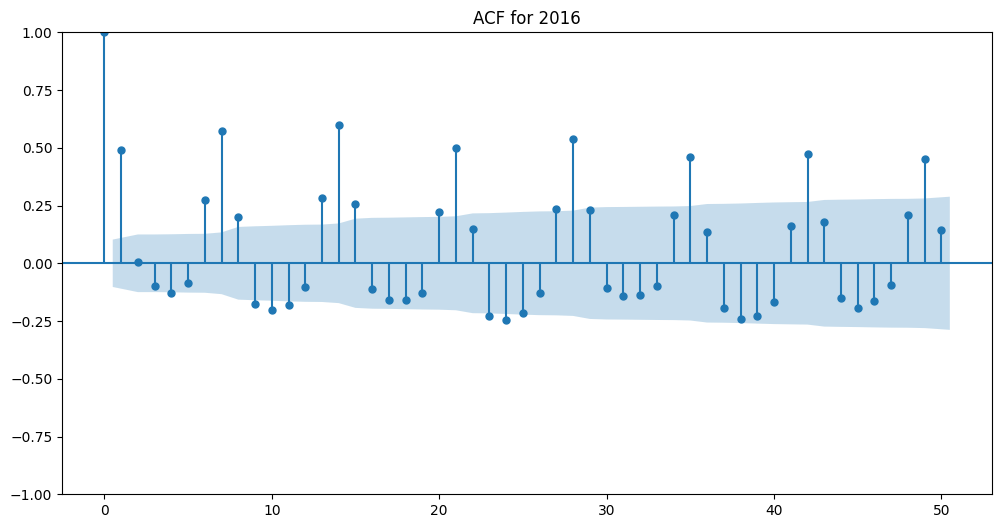

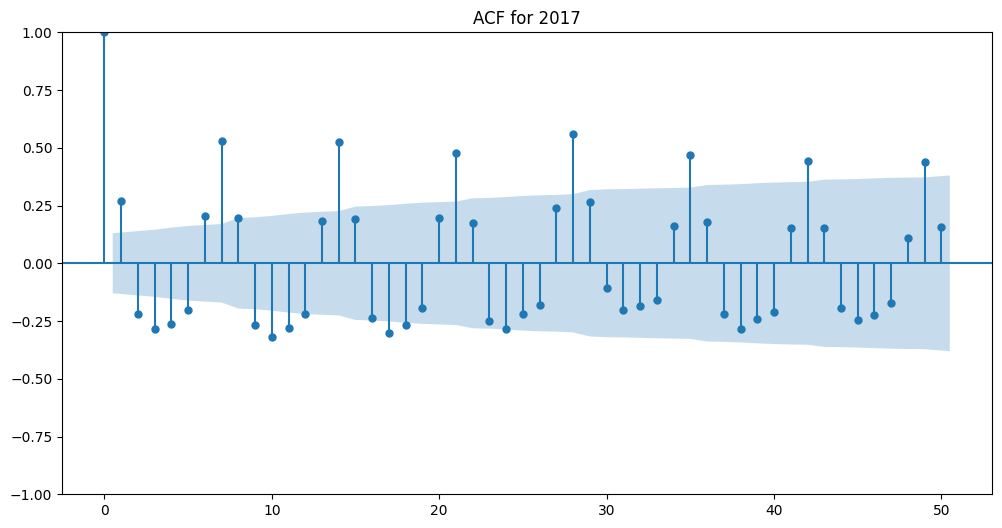

In [32]:
for year in range(2013, 2018):
    plot_acf(y.loc[str(year)]['sales'], lags=50, title=f"ACF for {year}")
    plt.show()

## Taking most recent year

Above charts acf charts differ for each year which may suggest that seasonality or trend has changed over time. Since I need to predict short future I decided to keep records of most recent year of training data

In [33]:
store_sales = store_sales.loc['2017']
average_sales = store_sales.groupby('date').mean()['sales']


## Seasonal plot

<Axes: title={'center': 'Seasonal Plot (week/day)'}, xlabel='day', ylabel='sales'>

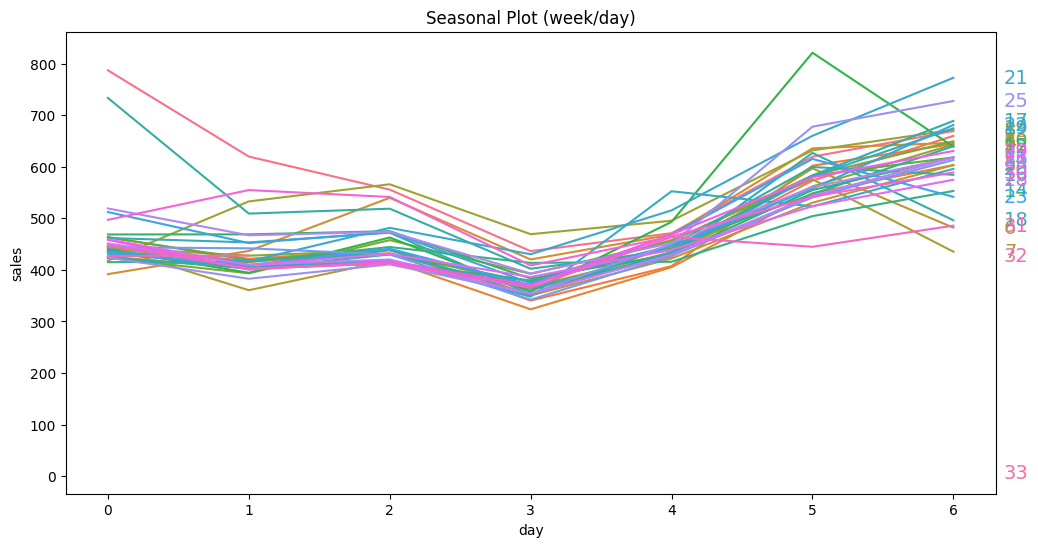

In [34]:
plt.rcParams["figure.figsize"] = (12, 6)  

X = average_sales.to_frame()
X['week'] = X.index.week
X['day'] = X.index.dayofweek

seasonal_plot(X, 'sales', period='week', freq='day')

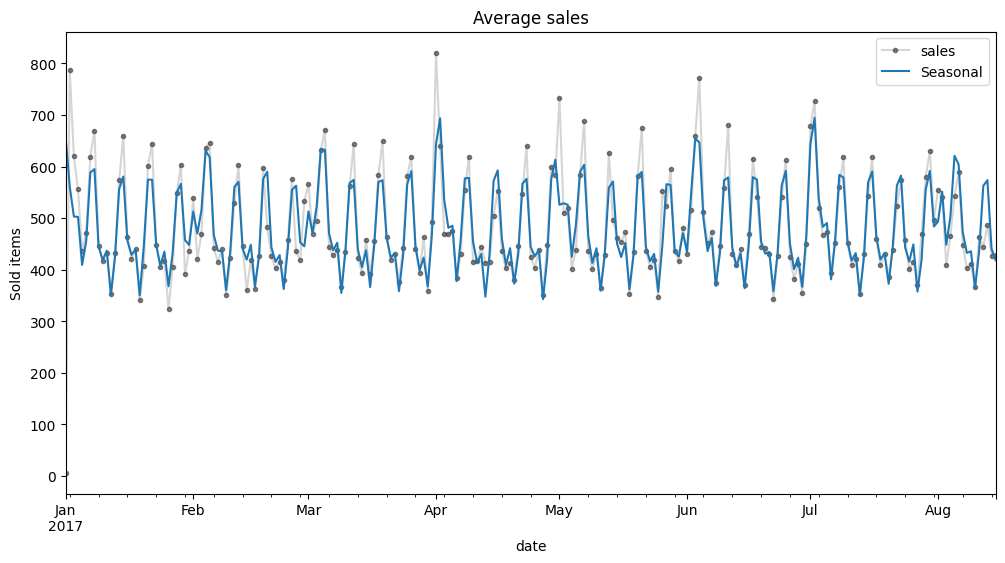

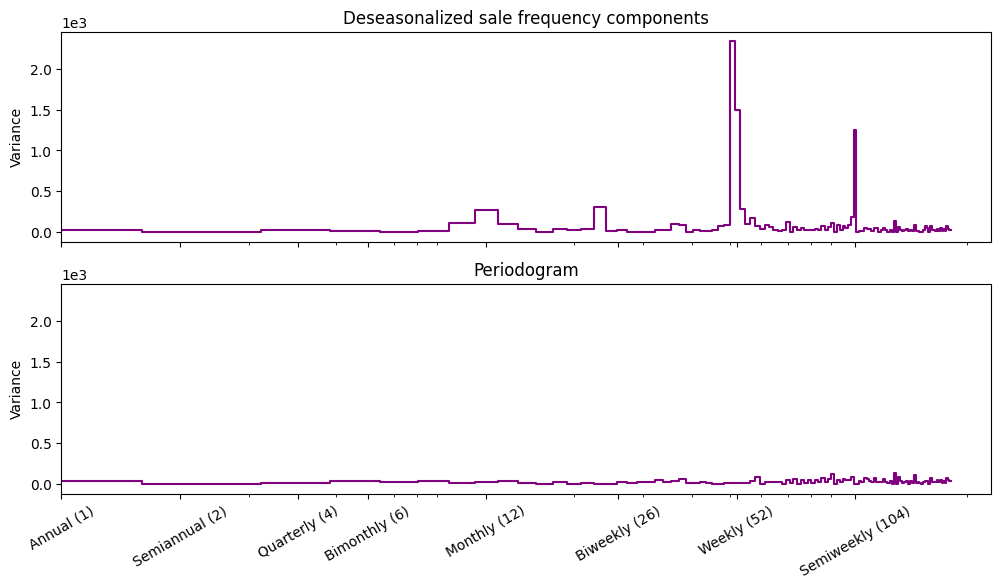

In [35]:
y = average_sales.copy()
y_pred = create_seasonal_features(y, freq='M', fourier_order=12, dp_order=1)
plot_average_sales(y, y_pred)
desesonalize_and_plot(y, y_pred)

The above chart shows that the model successfully captured seasonal variation in average sales

## Checking if holiday has predictive power

In [45]:
holidays = pd.read_csv(
    data_prepared_path / 'holidays.csv',
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
).set_index('date').to_period('D')

In [46]:
holidays_national = (
    holidays
    .query('locale in ["National"]')
    .loc['2017': '2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

holidays_regional = (
    holidays
    .query('locale in ["Regional"]')
    .loc['2017': '2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

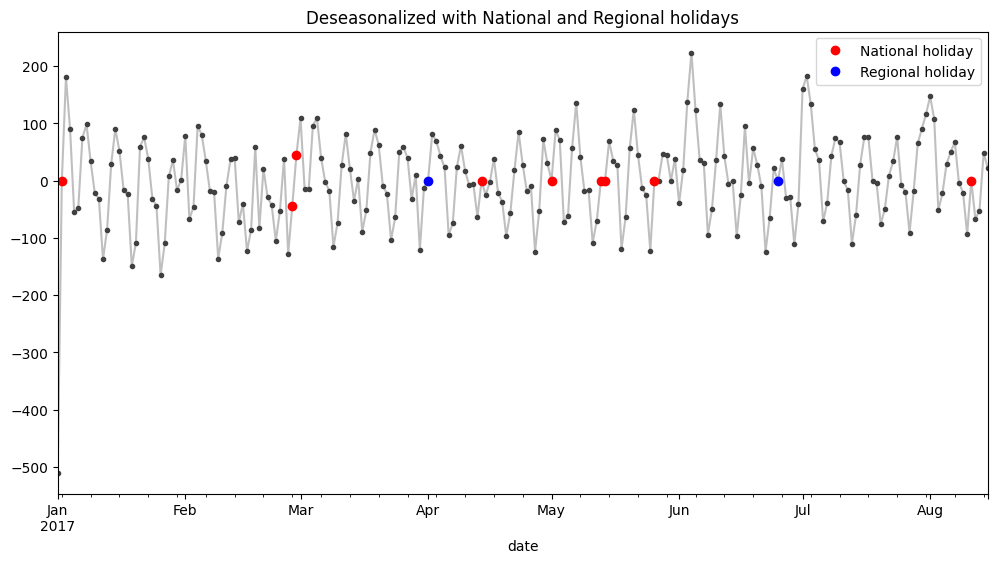

In [47]:
y_des = y - y_pred

ax = y_des.plot(**PLOT_PARAMS)
plt.plot_date(holidays_national.index, y_des[holidays_national.index], color='r', label='National holiday')
plt.plot_date(holidays_regional.index, y_des[holidays_regional.index], color='b', label='Regional holiday')
ax.set_title('Deseasonalized with National and Regional holidays')
ax.legend()

The plot suggest that the holidays often correspond to deviatiations in deseasonalized sales. It suggest that holidays may have significant impact in sales patterns

## Creating holiday features

In [48]:
from sklearn.preprocessing import OneHotEncoder

holidays = (
    holidays
    .query('locale in ["National", "Regional"]')
    .loc['2017': , ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

one_hot = OneHotEncoder(sparse_output=False)

X_holidays = pd.DataFrame(
    one_hot.fit_transform(holidays),
    index=holidays.index,
    columns=holidays['description'].unique()
)

In [50]:
X_holidays.index

PeriodIndex(['2017-01-02', '2017-02-27', '2017-02-28', '2017-04-01',
             '2017-04-14', '2017-05-01', '2017-05-13', '2017-05-14',
             '2017-05-26', '2017-06-25', '2017-08-11', '2017-10-09',
             '2017-11-02', '2017-11-03', '2017-11-06', '2017-11-07',
             '2017-12-21', '2017-12-22', '2017-12-23', '2017-12-24',
             '2017-12-25', '2017-12-26'],
            dtype='period[D]', name='date')

In [51]:
X2 = pd.merge(
    X.reset_index(),
    X_holidays.reset_index(),
    how='left',
    on='date'
).fillna(0.0).set_index('date')

## Checking prediction with holidays feature

In [53]:
X3 = X2.drop('sales', axis=1)

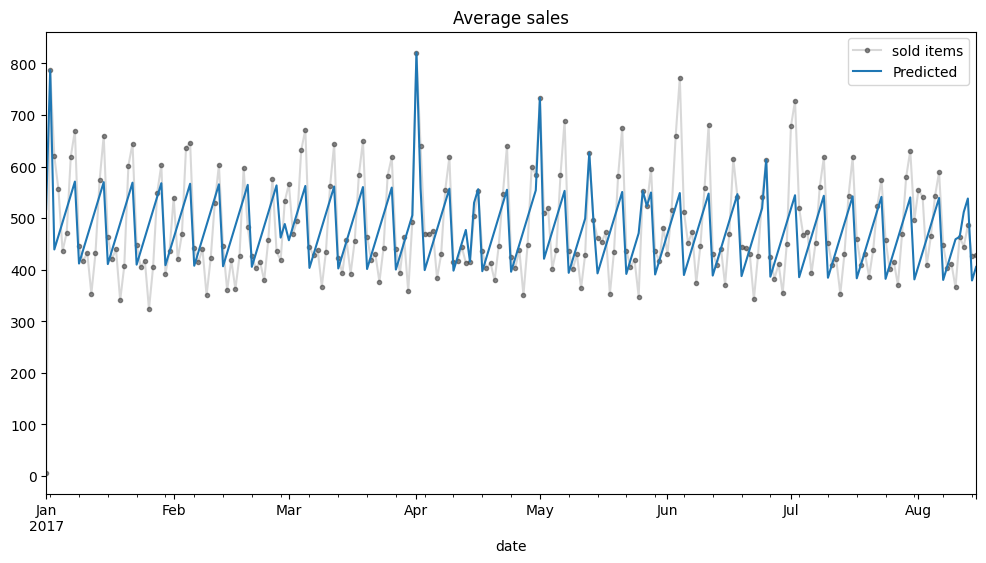

In [54]:
lm = LinearRegression().fit(X3, y)

y_pred = pd.Series(
    lm.predict(X3),
    index=X3.index,
    name='Fitted'
)

ax = y.plot(**PLOT_PARAMS, alpha=0.6, title='Average sales', label='sold items')
ax = y_pred.plot(ax=ax, label='Predicted')
ax.legend()

# Training the models

## Submission 2:
freq = M, order=12, Added holiday features

In [118]:
def add_is_new_year(X):
    X['is_new_year'] = (X.index.dayofyear == 1)
    
    return X

def add_holiday_features(X, holidays):
    X_with_holidays = pd.merge(
        X.reset_index(),
        holidays.reset_index(),
        how='left',
        on='date'
    ).fillna(0.0).set_index('date')
    
    return X_with_holidays

def pipeline(X, holidays):
    X = add_is_new_year(X)
    X = add_holiday_features(X, holidays)
    
    return X

def test_and_save_submission(dp: DeterministicProcess, X_holidays: pd.DataFrame, submission_name: str):
    df_test = pd.read_csv(
        data_path / 'test.csv',
        dtype={
            'store_nbr': 'category',
            'family': 'category',
            'onpromotion': 'uint32',
        },
        parse_dates=['date'],
        infer_datetime_format=True,
    )
    df_test['date'] = df_test.date.dt.to_period('D')
    df_test = df_test.set_index(['date', 'store_nbr', 'family'])

    # Create features for test set
    X_test = dp.out_of_sample(steps=16)
    X_test.index.name = 'date'
    X_test = pipeline(X_test, X_holidays)

    y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
    y_submit = y_submit.stack(['store_nbr', 'family'])
    y_submit.id = y_submit.id.astype(int)

    y_submit = y_submit.drop(columns=['id'], errors='ignore')  # Remove 'id' if it exists
    y_submit = y_submit.join(df_test[['id']]).reindex(columns=['id', 'sales'])
    y_submit.to_csv(f'submissions\store_sales\{submission_name}.csv', index=False)
    

In [72]:
y = store_sales.unstack(['store_nbr', 'family']).loc['2017']

fourier = CalendarFourier(freq='M', order=12)

dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X = pipeline(X, X_holidays)


In [73]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

Text(0.5, 1.0, 'PRODUCE Sales at Store 3')

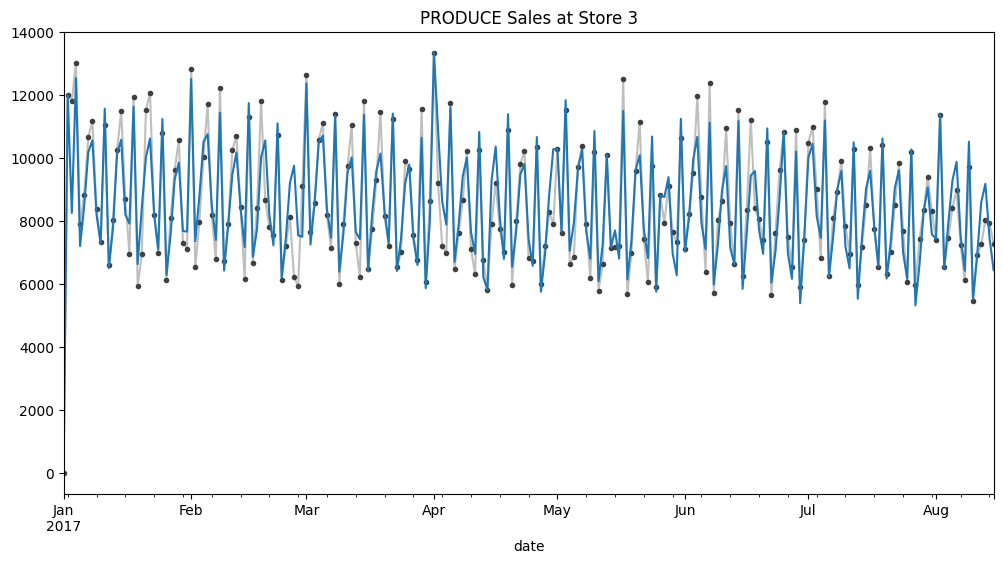

In [74]:

STORE_NBR = '3'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
# display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**PLOT_PARAMS)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}')

In [ ]:
test_and_save_submission(dp, X_holidays, 'submission_2')


## Submission 3:
